## Data Exploration and Preprocessing


In [33]:
import sklearn
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor as xgb
from sklearn.preprocessing import StandardScaler

In [2]:
import os
for dirname, _, filenames in os.walk('./Data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./Data\data_description.txt
./Data\sample_submission.csv
./Data\test.csv
./Data\train.csv


In [11]:
train_data = pd.read_csv('./Data/train.csv')
test_data = pd.read_csv('./Data/test.csv')
train_data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [4]:
train_data = train_data.dropna(subset = ['Neighborhood', 'HouseStyle', 'SaleCondition'])
train_data[['Neighborhood', 'HouseStyle', 'SaleCondition']]


,Neighborhood,HouseStyle,SaleCondition
0,CollgCr,2Story,Normal
1,Veenker,1Story,Normal
2,CollgCr,2Story,Normal
3,Crawfor,2Story,Abnorml
4,NoRidge,2Story,Normal
...,...,...,...
1455,Gilbert,2Story,Normal
1456,NWAmes,1Story,Normal
1457,Crawfor,2Story,Normal
1458,NAmes,1Story,Normal


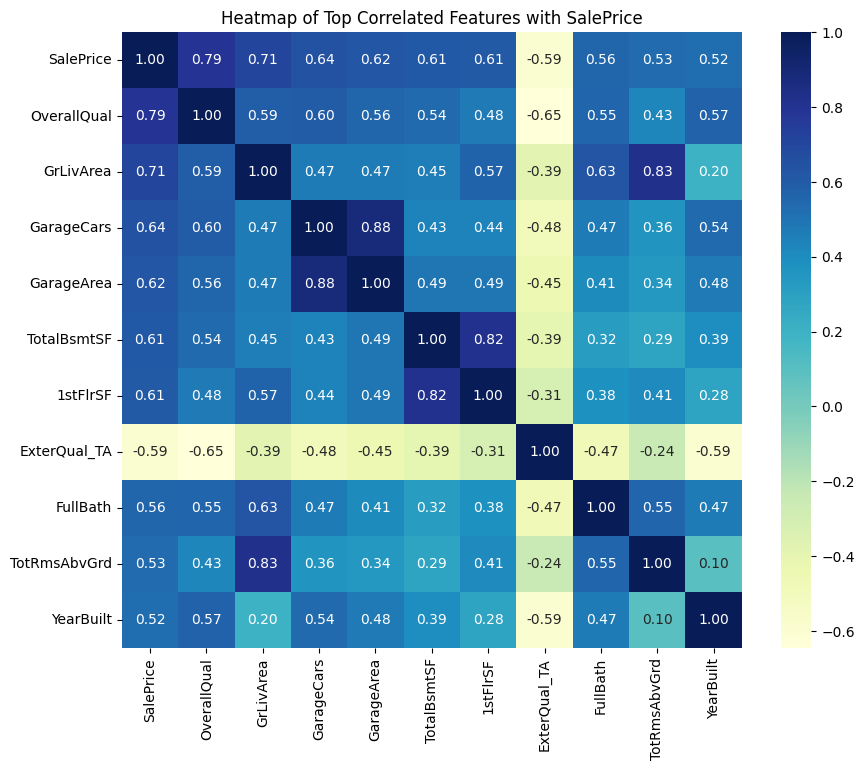

In [7]:
corr_matrix = train_data.corr(numeric_only=True)
top_corr = corr_matrix['SalePrice'].abs().sort_values(ascending=False).head(11)
top_features = top_corr.index

plt.figure(figsize=(10, 8))
sns.heatmap(train_data[top_features].corr(), annot=True, cmap='YlGnBu', fmt='.2f')
plt.title("Heatmap of Top Correlated Features with SalePrice")
plt.show()

# Data Cleaning
- Drop columns with over %30 null values
- Replace linear missing values in other columns with the median
- Replace categorial missing values in other columns with the mode

In [26]:
# Concatonate train and test data for easier data cleaning
train_data['train_test']=1
test_data['train_test']=0
test_data['SalePrice']=np.nan
df = pd.concat([train_data,test_data], axis=0).reset_index(drop=True)

#Drop columns with more than %30 null values
null_percent = df.isnull().mean()
drop_cols = null_percent[(null_percent > 0.3) & (null_percent.index != 'SalePrice')].index
df.drop(columns=drop_cols, inplace=True)

# Fill numeric columns with median
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

# Fill categorical columns with mode
df = df.fillna(df.mode().iloc[0])

print("'SalePrice' in df.columns:", 'SalePrice' in df.columns)
print("Remaining missing values:", df.isnull().sum().sum())


'SalePrice' in df.columns: True
Remaining missing values: 0


### One-hot encoding of categorial columns

In [27]:
# Apply one-hot encoding
df_encoded = pd.get_dummies(df, drop_first=True)

# Split back into train and test sets
train_df = df_encoded[df_encoded['train_test'] == 1].copy()
test_df = df_encoded[df_encoded['train_test'] == 0].copy()

# Define features and target
X = train_df.drop(['SalePrice', 'train_test', 'Id'], axis=1)
y = train_df['SalePrice']
X_test_final = test_df.drop(['SalePrice', 'train_test', 'Id'], axis=1)

# Confirm dimensions
print("X shape:", X.shape)
print("y shape:", y.shape)
print("X_test_final shape:", X_test_final.shape)

X shape: (1460, 229)
y shape: (1460,)
X_test_final shape: (1459, 229)


## Train Model
Using XGBoost Regression Model

In [34]:
# Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_val)
xgb_rmse = np.sqrt(root_mean_squared_error(y_val, xgb_preds))
xgb_mse = np.sqrt(mean_squared_error(y_val, xgb_preds))
print("XGBoost RMSE:", xgb_rmse)
print("XGBoost MSE:", xgb_mse)

XGBoost RMSE: 169.05481870328865
XGBoost MSE: 28579.53172680179


In [37]:
#test 1: RMSE: 115.14711208656081 (First was better, why?)
#test 2: RMSE: 169.05481870328865

In [36]:
# Final training on full train_df
final_model = XGBRegressor(random_state=42)
final_model.fit(train_df.drop(['SalePrice', 'train_test', 'Id'], axis=1), train_df['SalePrice'])

# Predict on test set
final_preds = final_model.predict(test_df.drop(['SalePrice', 'train_test', 'Id'], axis=1))

# Prepare submission file
submission = pd.DataFrame({
    'Id': test_df['Id'],
    'SalePrice': final_preds
})

# Reset row index before saving
submission = submission.reset_index(drop=True)

# Save to CSV for submission
submission.to_csv("submission.csv", index=False)

# Preview first few rows
submission.head()

,Id,SalePrice
0,1461,125100.250000
1,1462,167372.859375
2,1463,187066.265625
3,1464,187591.406250
4,1465,196547.328125
